# A tour of TSP heuristics

<center><img src=https://imgs.xkcd.com/comics/travelling_salesman_problem.png width=450></center>

## Preliminaries

### Modelisation

Let $G = (V, {E})$, where $V$ is a set of **vertices** and a set of **arcs**, be a **undirected** **weighted** **complete** graph:
- **undirected**: every ${e} \in {E}$ is a 2-set ${e} = \{u, v\}$, representing a two-way direction between $u \in V$ and $v \in V$.  
- **weighted**: every ${e} = (u, v) \in {E}$ has a weight $d(u, v)$ (the distance from $u$ to $v$).  
- **complete**: $G$ contains all possible arcs from a vertex to another.

> **Travelling Salesman Problem (TSP)**: find a cycle (or: tour) in $G$ visiting all vertices with minimum total weight

In this notebook we will restrict ourself to the **Euclidean TSP**, in which each vertex is a 2D point and $d$ is the euclidean distance between two points.

### Data structures

We will use a numpy array of size $n\times 2$ to store $n$ points. We will test our algorithms on random points:

In [2]:
import numpy as np
from functools import cache

@cache # to compare algorithms on same data
def random_cities(n: int) -> np.array: # generate n points (x, y) with 0 <= x < 1000 and 0 <= y < 400
    return np.random.uniform(0, (1000, 400), size=(n, 2))

random_cities(4)

array([[586.15852197,  65.54142125],
       [850.39553842, 115.52131908],
       [201.43691022,  58.18104701],
       [128.00034792,  80.38916352]])

A cycle will be  a list of points containing the vertices in the order they appear in the cycle. The length of a cycle is the sum of the euclidean distances between each vertex and the next:

In [3]:
def d(p, q):
    return np.sum((p - q)**2, axis=-1)**.5
    
def length_cycle(cycle: list) -> float:
    return d(cycle, np.roll(cycle, 1, axis=0)).sum()

length_cycle(random_cities(4))

1455.529010060583

An algorithm for TSP will be implemented as a function with a set of points as argument and returning a cycle:

In [4]:
def algo(points: np.array) -> np.array:
    return ... # cycle

### Vizualisation

In [198]:
import matplotlib.pyplot as plt
import time

def plot_cycle(cycle):
    cycle = list(cycle)
    # print(cycle)
    plt.figure(figsize=(20, 6))
    X, Y = zip(*(cycle + [cycle[0]]))
    plt.plot(X, Y, 'bo-')
    plt.scatter(X[0], Y[0], s=300) # starting point

def test_points(algo, points):
    t = time.time()
    cycle = list(algo(points))
    plot_cycle(cycle)
    plt.suptitle(f"Cycle length: {length_cycle(cycle):.2f}\nTime: {time.time() - t:.2f}s", fontsize=20)

def test(algo, n): # test algorithm on n random cities
    test_points(algo, random_cities(n))

def test_multiple(algos, legends, n): # compare several algorithms on n random cities
    points = random_cities(n)
    n_row = (n+1)//2
    _, axes = plt.subplots(n_row, 2, figsize=(20, 5*n_row))
    for i, cycle in enumerate(cycles):
        cycle = list(cycle)
        X, Y = zip(*(cycle + [cycle[0]]))
        a = axes.flat[i]
        a.plot(X, Y, 'bo-')
        a.scatter(X[0], Y[0], s=300) # starting point
        a.set_title(f"Cycle length: {length_cycle(cycle):.2f} ({legends[i]})", fontsize=20)

We will also take a look at a real graph, containing the 18 most populated cities in France:

In [128]:
import folium # for map vizualization
import pandas as pd

df = pd.read_csv("./cog_ensemble_2021_csv/commune2021.csv");

def test_france(algo, n):
    f = folium.Figure(width=800, height=400)
    m = folium.Map(location=[46.3833, 4.91667], zoom_start=5)
    df_big = df.sort_values(by=['ville_population_2012'])[["ville_nom", "ville_population_2012", "ville_latitude_deg", "ville_longitude_deg"]][-n:]
    for i in range(len(df_big)):
        # print(df.loc[i, "ville_latitude_deg"], df.loc[i, "ville_longitude_deg"])
        city = df_big.iloc[i]
        folium.CircleMarker(
            location=[city["ville_latitude_deg"], city["ville_longitude_deg"]],
            popup=city["ville_nom"] + " (" + str(city["ville_population_2012"]) + ")",
            icon=folium.Icon(color="green"),
            color="#3186cc",
            fill=True,
            radius=10,
        ).add_to(m)

    points = df_big[["ville_latitude_deg", "ville_longitude_deg"]].to_numpy()
    cycle = list(algo(points))
    cycle.append(cycle[0])
    folium.PolyLine(cycle).add_to(m)
    f.add_child(m)
    return f

## Exact algorithms

### Brute force

The most simple solution is to consider all possible cycles and keep the minimum. This amounts to enumerate all permutations of the vertices:

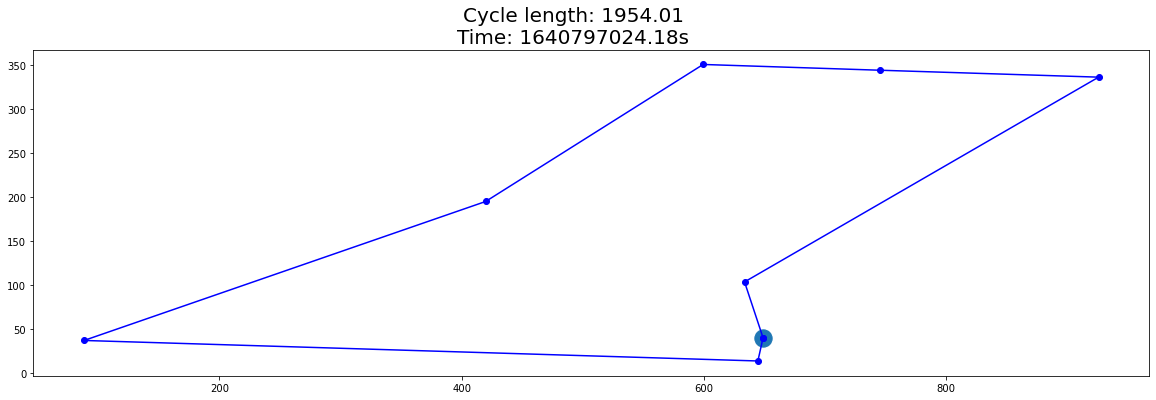

In [153]:
from itertools import permutations

def all_cycles(cities):
    for perm in permutations(cities[1:]):
        yield [cities[0]] + list(perm) # first city is fixed
            
def algo_brute_force(cities):
    cycles = all_cycles(cities)
    return min(cycles, key=length_cycle)

test(algo_brute_force, 8)

The time complexity is O($n!$) (number of permutation of the $n$ cities), which is horrendous and unusable for $n > 10$.

In [9]:
test_france(algo_brute_force, 8)

### Dynamic programming (Held–Karp algorithm)

Assume that $V = \{0, ..., n - 1\}$. Let $S \subseteq \{1, ..., n - 1\}$ and $v \notin S$.  
Let $dp[S, v]$ be the length of a shortest cycle starting at $0$, visiting once every vertex of $S$, and ending in $v$.  
We use the following induction:
$$dp[\emptyset, v] = d(0, v)$$
$$dp[S, v] = \min_{u \in S} dp[S - u, u] + d(u, v)$$

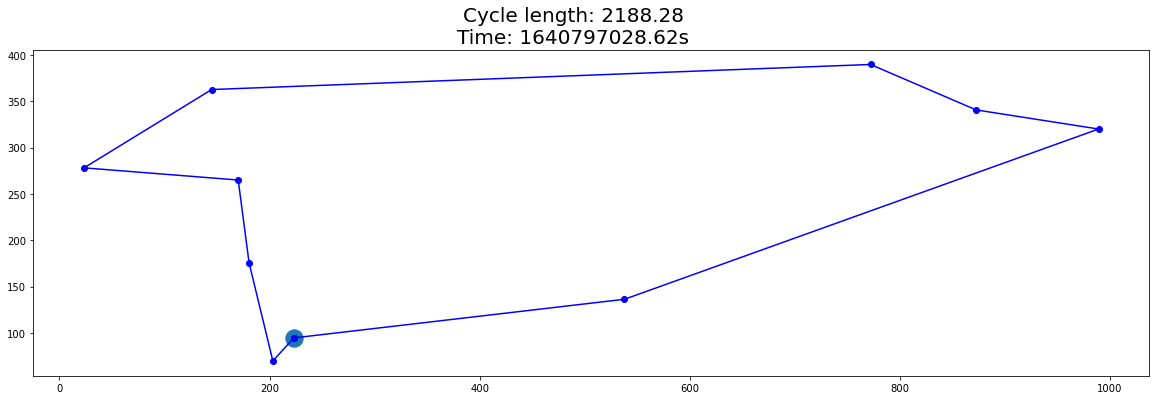

In [154]:
def algo_dp(points):
    def dS(u, v):
        return d(points[u], points[v])

    @cache
    def dp(S, v):
        if len(S) == 0:
            return dS(0, v)
        return min(dp(S - {u}, u) + dS(u, v) for u in S)
    
    def pred(S, v):
        yield points[v]
        if len(S) == 0:
            return points[0]
        u = min((dp(S - {u}, u) + dS(u, v), u) for u in S)[1]
        yield from pred(S - {u}, u)
    
    S = frozenset(range(len(points))) - {0}
    return list(pred(S, 0))
        
test(algo_dp, 10)

In [11]:
test_france(algo_dp, 15)

Unfortunately the complexity is still exponential: O($n2^n$) since we need to compute $dp[S, v]$ for $S \subseteq \{1, ... n - 1\}$ ($2^{n - 1}$ subsets) and $v \in V$ ($n$ vertices).

## Greedy algorithms 

### Nearest neighbors

The nearest neighbors algorithm consists in starting in an arbitrary vertex then iteratively visiting the closest non-visited vertex.

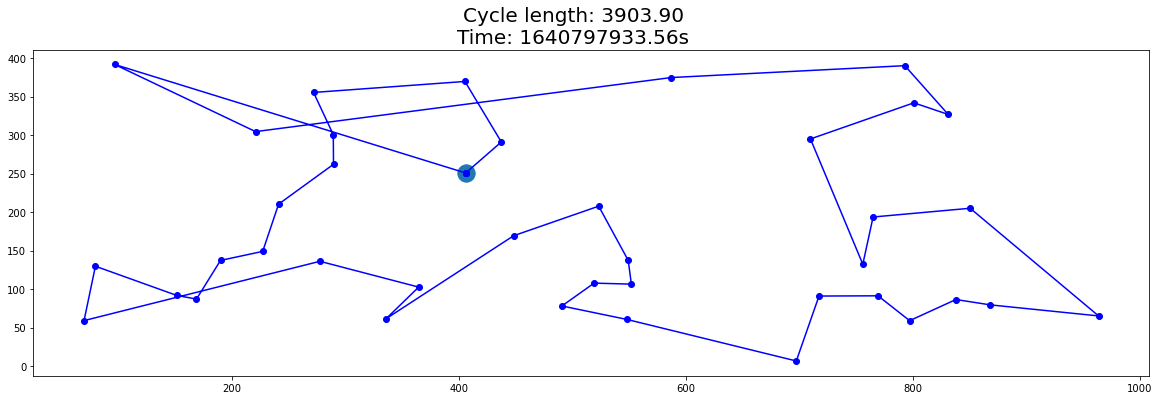

In [174]:
def closest(i, points):
    p = points[i].copy()
    points[i][0] = np.inf
    j = np.argmin(np.sum((points - p)**2, axis=1))
    return j, p
    
def algo_nn(points):
    import copy
    j = 0
    points_copy = copy.deepcopy(points)
    for _ in range(len(points)):
        j, p = closest(j, points_copy)
        yield p
    yield points[0]

test(algo_nn, 40)

### Local search: uncrossing for nearest neighbors (2-opt)

We can observe that there are often "big jumps" in the nearest neighbors solution, like this:

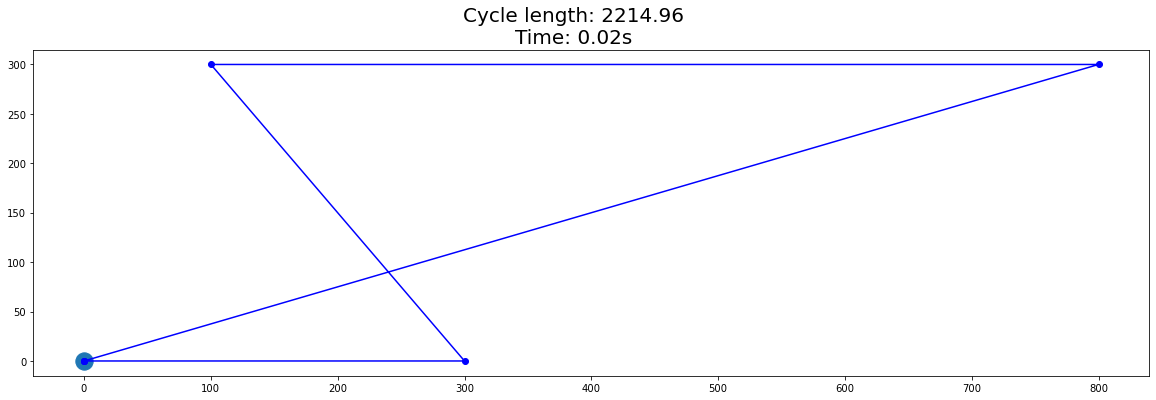

In [199]:
points = np.array([[0, 0], [300, 0], [100, 300], [800, 300]], dtype=float)
test_points(algo_nn, points)

This can be improved by "uncrossing":

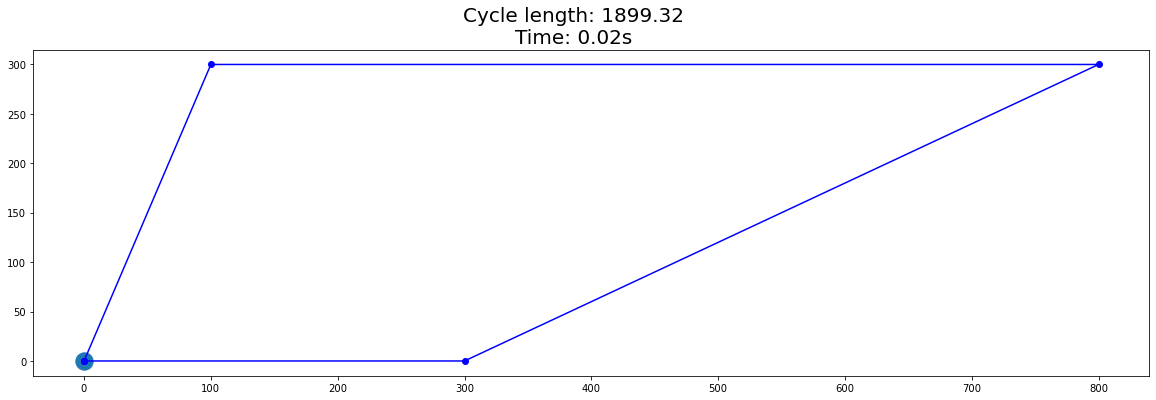

In [204]:
def uncrossing(p): # uncross every pair of edges in path p
    n = len(p)
    b = False # has an improvment been made?
    for i in range(n):
        for j in range(i + 1, n):
            if d(p[i], p[(i+1)%n]) + d(p[j], p[(j+1)%n]) > d(p[i], p[j]) + d(p[(i+1)%n], p[(j+1)%n]):
                p[i + 1:j+1] = p[i + 1:j+1][::-1]
                b = True
    return b

def algo_uncrossing(algo):
    def aux(points):
        path = list(algo(points))
        while uncrossing(path):
            pass
        return path
    return aux

test_points(algo_uncrossing(algo_nn), points)

The loop `while uncrossing(path)` is terminating since the length of `path` is decreasing by at least $c$ for each iteration, where $c$ is the minimum of non-zero distance gained by uncrossing any two edges.

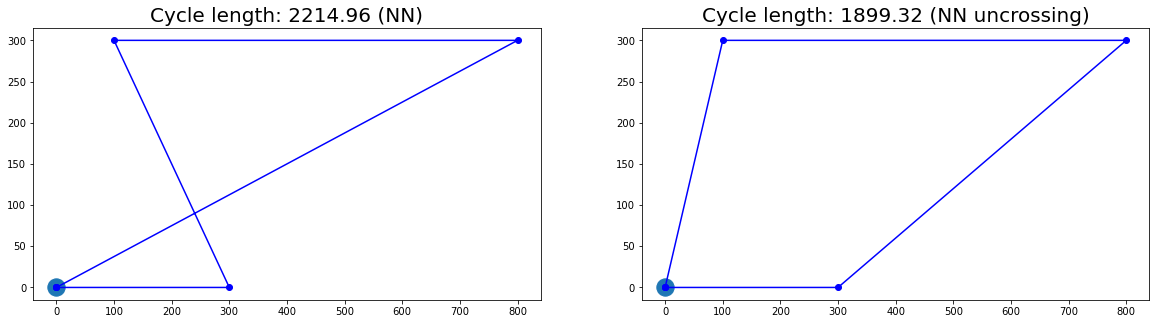

In [202]:
plot_cycles([algo(points) for algo in (algo_nn, algo_uncrossing(algo_nn))], ["NN", "NN uncrossing"])

## Genetic algorithm

We will apply the following genetic algorithm:  
1. **Generate an initial population**: a set of cycles randomly generated  
2. **Keep only the best individuals**: the shortest half  
3. **Crossover**: combine two cycles into one
4. **Mutate the individuals**: exchange two vertices at random from each cycle, with some probability `mutation_rate`

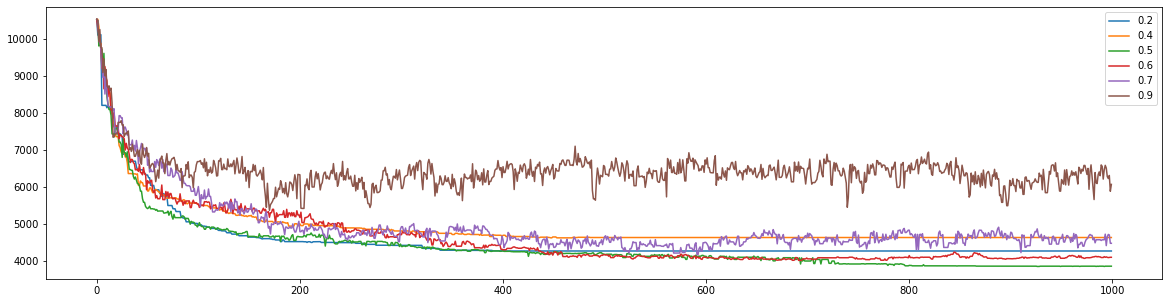

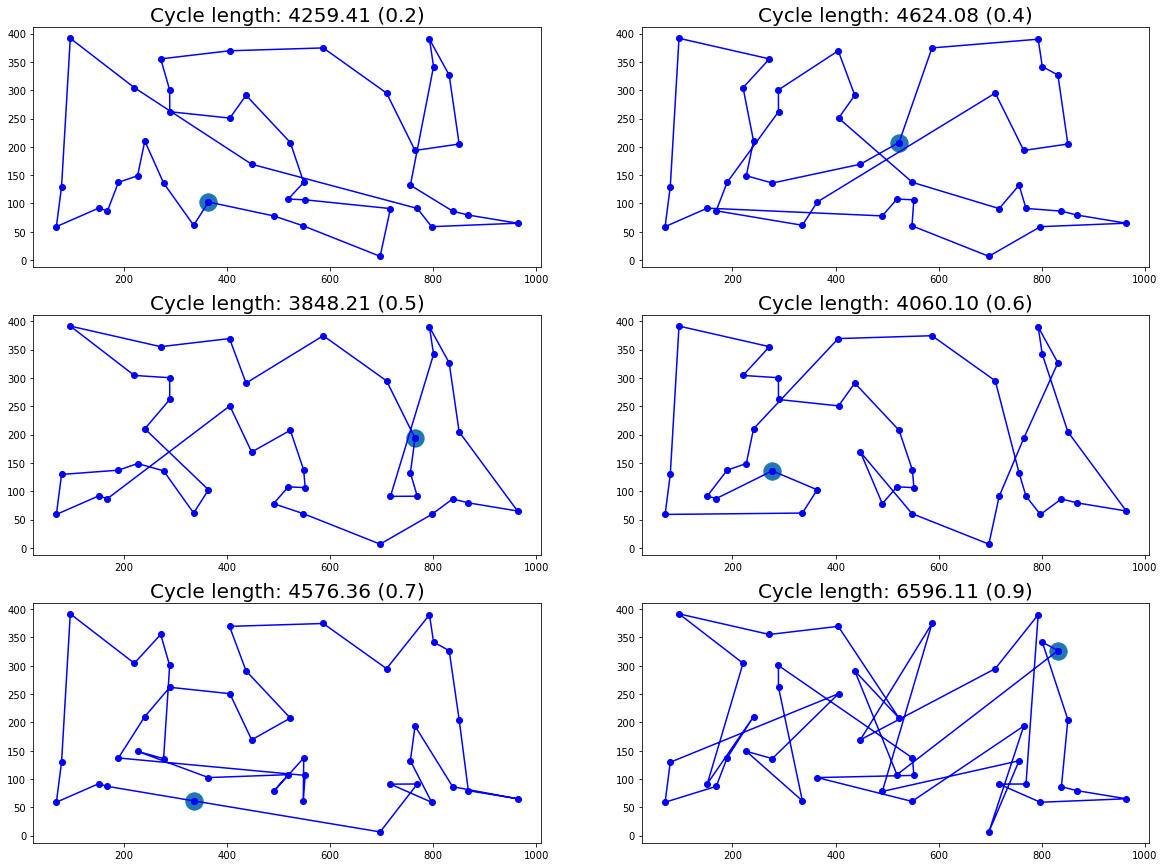

In [176]:
from multiprocessing import Pool

def initial_population(points, sz_pop):
    return [list(map(tuple, np.random.permutation(points))) for _ in range(sz_pop)]

def crossover(cycle1, cycle2):
    n = len(cycle1)
    cycle = cycle1[:n//2]
    for p in cycle2:
        if p not in cycle:
            cycle.append(p)
    return cycle

def mutate(pop, mutation_rate):
    for i in range(len(pop)):
        if np.random.random() < mutation_rate:
            j, k = np.random.choice(range(len(pop[i])), 2)
            pop[i][j], pop[i][k] = pop[i][k], pop[i][j]

def algo_genetic(points, sz_pop=1000, n_iterations=1000, mutation_rate=0.1):
    Y = [] # length of the best cycle for each iteration
    pop = initial_population(points, sz_pop)
    for _ in range(n_iterations):
        pop.sort(key=length_cycle)
        Y.append(length_cycle(pop[0]))
        pop = pop[:len(pop)//2]
        pop.extend([crossover(pop[i-1], pop[i]) for i in range(len(pop))])
        mutate(pop, mutation_rate)
    return min(pop, key=length_cycle), (Y, mutation_rate)

points = random_cities(40)
proba_mut = [0.2, 0.4, 0.5, 0.6, 0.7, 0.9]
with Pool(6) as pool:
    def f(p):
        return algo_genetic(points, mutation_rate=p)
    cycles, Y_list = zip(*pool.map(f, proba_mut))
plt.figure()
for Y, mut in Y_list:
    plt.plot(range(len(Y)), Y, label=mut)
plt.legend()
plot_cycles(cycles, proba_mut)
plt.show()

## Branch and bound

## Comparison

genetic
6982.998882833866
nn uncrossing
3558.231569468827
3515.2453462314534
3450.620624150279
3450.620624150279


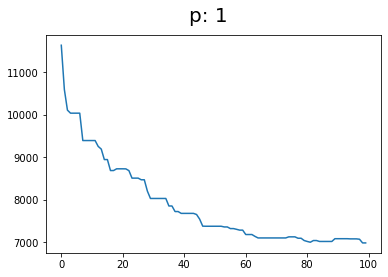

In [41]:
plt.rcParams["figure.figsize"] = (20,3)
n = 40
points = random_cities(n)
for algo, name in [(algo_genetic, "genetic"), (algo_nn_uncrossing, "nn uncrossing")]:
    print(name)
    print(length_cycle(algo(points)))